<a href="https://colab.research.google.com/github/BeeGassy/Deep-Q-Learning/blob/main/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym.wrappers import FrameStack
from pdb import set_trace
import random
from tqdm.notebook import trange
import atari_py
from google.colab import output
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64

In [2]:
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

<IPython.core.display.Javascript object>

In [3]:
class Model(nn.Module):
  #takes the # of frames stacked and the possible outputs (move right, left, etc)
  def __init__(self, numberStacked, possibleOutputs):
    super(Model, self).__init__()
    hiddenKernels = 8
    #layer_one_hiddenKernels = 54
    #layer_two_hiddenKernels = 6

    #sizePostConvolution = 525824 
    sizePostConvolution = 262912
    #sizePostConvolution = 134400
    #self.conv1 = nn.Conv2d(in_channels = numberStacked, out_channels = layer_one_hiddenKernels, kernel_size = 2, stride = 2, padding = 1)
    self.conv1 = nn.Conv2d(numberStacked, hiddenKernels, 2)
    self.rl = nn.ReLU()
    self.conv2 = nn.Conv2d(hiddenKernels, hiddenKernels, 2)
    #self.conv2 = nn.Conv2d(in_channels = numberStacked, out_channels = layer_two_hiddenKernels, kernel_size = 2, stride = 2, padding = 1)
    self.fc1 = nn.Linear(sizePostConvolution, possibleOutputs)

  def forward(self, stackedState):
    x = self.conv1(stackedState)
    x = self.rl(x)
    x = self.conv2(x)
    x = x.view(x.size(0), -1)
    #x = x.view(-1, x.size()[1] * x.size()[2] * x.size()[3])
    #print(x.size())
    x = self.fc1(x)
    return x

In [4]:
class Agent():
  def __init__(self, size, numberStacked, possibleOutputs, gamma):
    self.replay_buffer_size = size
    self.replay_buffer_list = []
    self.model = Model(numberStacked, possibleOutputs)
    self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3, weight_decay=1e-5)
    self.lossFn = torch.nn.MSELoss()
    self.gamma = gamma
    self.batch_size = 10

  def action_value(self, input_state):
    with torch.no_grad():
        q_val = self.model(input_state)
    action = torch.argmax(q_val)
    return action

  def sample_replay_buffer(self, batch_size):
    mini_batch = random.sample(self.replay_buffer_list, batch_size)
    return mini_batch

  def SGD(self):
    mini_batch = self.sample_replay_buffer(self.batch_size)
    for batch in mini_batch:
        self.optimizer.zero_grad()
        state, action, reward, next_state, done = batch
        predicted_q_val = self.model(state)
        predicted_reward = torch.max(predicted_q_val)
        #predicted_next_state, predicted_reward, done, _ = d.test_env.step(predicted_action)
        yj = torch.FloatTensor([reward])
        if done:
          if isinstance(yj, float):
            print("this is yj", yj)
          loss = self.lossFn(predicted_reward, yj.detach())
          loss.backward()
          self.optimizer.step()
          break

        target_q_val = self.model(next_state)
        #print("target_q_val: ", target_q_val)
        yj += self.gamma * torch.max(target_q_val)
        loss = self.lossFn(predicted_reward, yj)
        loss.backward()
        self.optimizer.step()

    return loss
  
  def addToReplay(self, newInput):
    if len(self.replay_buffer_list) >= self.replay_buffer_size:#random eviction
        toEvict = random.randint(0, self.replay_buffer_size - 1)
        del self.replay_buffer_list[toEvict]
    self.replay_buffer_list.append(newInput)

In [5]:
class DQN():
  def __init__(self):
    self.episodes = 400
    self.time_in_episode = 1000000
    self.epsilon = 0.7
    self.possibleOutputs = 6
    self.gamma = 0.01
    self.rbSize = 10000
    self.numberStacked = 4
    self.height = 210
    self.width = 160
    #self.height = 84
    #self.width = 84
    self.agent = Agent(self.rbSize, self.numberStacked, self.possibleOutputs, self.gamma)
    PONG = 'PongNoFrameskip-v4'
    CARTPOLE = 'CartPole-v1'
    self.test_env = gym.make(PONG)
    self.test_env = self.stack_frames(self.test_env, self.numberStacked)
    #self.test_env = Recorder(test_env, './video', 30)
    prev_screen = self.test_env.render(mode='rgb_array')
    
  def initTransition(self):
    state = self.test_env.reset()   
    action = self.test_env.action_space.sample()
    next_state, reward, done, _ = self.test_env.step(action)
    grey_scaled_state = self.preprocessing(state)
    grey_scaled_next_state = self.preprocessing(next_state)
    transition = (grey_scaled_state, action, reward, grey_scaled_next_state)
    self.agent.addToReplay((grey_scaled_state, action, reward, grey_scaled_next_state, done))

    return transition

  def execute_action(self, input_action, state):
    next_state, reward, done, _ = self.test_env.step(input_action)
    grey_scaled_next_state = self.preprocessing(next_state)
    grey_scaled_state = state
    
    transition = (grey_scaled_state, input_action, reward, grey_scaled_next_state, done)
    self.agent.addToReplay((grey_scaled_state, input_action, reward, grey_scaled_next_state, done))

    return transition

  def preprocessing(self, input_next_state):
    if torch.is_tensor(input_next_state) or not isinstance(input_next_state, gym.wrappers.frame_stack.LazyFrames):
      input_next_state = input_next_state.numpy()

      np_next_state = np.transpose(input_next_state, (0, 3, 1, 2))
    else:
      np_next_state = np.transpose(input_next_state, (0, 3, 1, 2))#batch h w color to batch color h w

    copy_next_state = np_next_state.copy()

    torch_next_state = torch.tensor(copy_next_state, dtype=torch.float)

    transform = T.Grayscale()
    #transform = T.Compose([ T.Grayscale(), T.ToTensor(), T.ToPILImage()])


    grey_scaled_next_state = transform(torch_next_state)
    grey_scaled_next_state = grey_scaled_next_state.view(1, self.numberStacked, self.height, self.width)

    return grey_scaled_next_state


  #stack the frames of the states in group of 4. 4 Frames per stack
  def stack_frames(self, input_env, stack_count):
    enviroment = FrameStack(input_env, stack_count)

    return enviroment
  
  def train(self):
    for e in trange(self.episodes):
        rewardVal = 0
        
        #initialize episode and get first transition
        initial_transition = self.initTransition()
        if e % 40 == 0 and e > 0:
            prev_screen = self.test_env.render(mode='rgb_array')
            plt.imshow(prev_screen)
        state, action, reward, next_state = initial_transition

        episodeDone = False
        time_step = 0
        while not episodeDone:
            random_action_prob = random.uniform(0.0, 1.0)
            if random_action_prob < self.epsilon:
                action = self.test_env.action_space.sample()
            else: 
            #perform action for timestep
                action = self.agent.action_value(next_state)

            #only render every 40 episodes
            if e % 40 == 0 and e > 0:
                screen = self.test_env.render(mode='rgb_array')
                plt.imshow(screen)
                ipythondisplay.clear_output(wait=True)
                ipythondisplay.display(plt.gcf())
                
            state, action, reward, next_state, done  = self.execute_action(action, next_state)
            
            #send all information into our replay buffer so we can test on it within SGD
            self.agent.addToReplay((state, action, reward, next_state, done))
            
            if ((self.agent.replay_buffer_size + 1) % self.agent.batch_size) == 0:
                self.agent.SGD()
                
            #perform epsilon decay
            episode = e + 1
            epsilon_decay_rate = max((episode - time_step) / episode, 0)
            self.epsilon -= epsilon_decay_rate
            if time_step >= self.time_in_episode or done:
                episodeDone = True
                self.test_env.reset() 
            time_step += 1 
            
    ipythondisplay.clear_output(wait=True)
    self.test_env.close()

KeyboardInterrupt: ignored

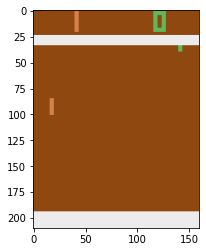

In [6]:
if __name__ == "__main__":
  torch.device("cuda" if torch.cuda.is_available() else "cpu")
  d = DQN()
  DQN.train(d)
  torch.save(d.state_dict(), 'filepath')
  display.stop()
  #good music
  output.eval_js('new Audio("https://r2---sn-p5qlsnsy.googlevideo.com/videoplayback?expire=1618497789&ei=nfx3YLKsELbFlu8P1-64kAY&ip=2600%3A6c64%3A617f%3Abc5a%3A7907%3Aa000%3A7803%3A3c36&id=o-APG1Ow_7Rqcg0H0bk7JmTNziXwYM7ry1DI6oNTus0dER&itag=140&source=youtube&requiressl=yes&mh=zs&mm=31%2C26&mn=sn-p5qlsnsy%2Csn-vgqsknek&ms=au%2Conr&mv=m&mvi=2&pl=32&initcwndbps=2115000&vprv=1&mime=audio%2Fmp4&ns=M8BvnU-4jKyiTm1H_RN4k2gF&gir=yes&clen=58313743&dur=3603.156&lmt=1608958308129032&mt=1618475814&fvip=2&keepalive=yes&fexp=24001373%2C24007246&c=WEB&txp=5431432&n=smqEWuAyGOahL3a&sparams=expire%2Cei%2Cip%2Cid%2Citag%2Csource%2Crequiressl%2Cvprv%2Cmime%2Cns%2Cgir%2Cclen%2Cdur%2Clmt&lsparams=mh%2Cmm%2Cmn%2Cms%2Cmv%2Cmvi%2Cpl%2Cinitcwndbps&lsig=AG3C_xAwRQIhAJmKS1ok3DYa04xuKWXRFw6MtJR1ljH66_SW8kE3aq36AiANxg9hEPXANBSNnPBdJIrm8oGF32qcLZxmAqJvtYJJaQ%3D%3D&sig=AOq0QJ8wRQIgSUW-LfEl4Uq8SDC_te4-sqaPRL90RFvIw-xMWmkUADYCIQD8BSmGoAxff-PQruNK4vf5vVXv1Uc5dWK1PHh8EOM40g==").play()')
  #bad music
  #output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
